# Fitting conductances of whole-cell models

This tutorial


## General approach


- [Models are written in Myokit's MMT syntax](https://myokit.readthedocs.io/syntax/index.html), usually by [downloading a CellML model](https://models.cellml.org/electrophysiology) and then [importing it](https://myokit.readthedocs.io/api_formats/cellml.html).
- [Simulations are run](https://myokit.readthedocs.io/api_simulations/Simulation.html) using the `Simulation` class, which uses CVODE to solve the ODEs.
- [A pints.ForwardModel](https://github.com/pints-team/pints/blob/master/examples/optimisation/first-example.ipynb) is wrapped around a Myokit simulation.
- [A pints.ErrorMeasure](https://pints.readthedocs.io/en/latest/error_measures.html) or [pints.LogLikelihood](https://pints.readthedocs.io/en/latest/log_likelihoods.html) is defined
- [Optimisation](https://nbviewer.jupyter.org/github/pints-team/pints/blob/master/examples/optimisation-first-example.ipynb) or [Bayesian inference](https://nbviewer.jupyter.org/github/pints-team/pints/blob/master/examples/sampling-first-example.ipynb) is run.



## Fitting to action potential

## Fitting to action potential and calcium transient

In [2]:
import numpy as np
import pints
import myokit
import matplotlib.pyplot as plt

class MyokitModel(pints.ForwardModel):
    """
    This is a pints model, i.e. a statistical model that takes parameters and
    times as input, and returns simulated values.
    """
    def __init__(self):
        m, p, _ = myokit.load('resources/beeler-1977.mmt')
        self.simulation = myokit.Simulation(m, p)

    def n_parameters(self):
        return 5

    def n_outputs(self):
        return 2

    def simulate(self, parameters, times):

        self.simulation.reset()
        self.simulation.set_constant('ina.gNaBar', parameters[0])
        self.simulation.set_constant('ina.gNaC', parameters[1])
        self.simulation.set_constant('isi.gsBar', parameters[2])
        self.simulation.set_constant('ik1.gK1', parameters[3])
        self.simulation.set_constant('ix1.gx1', parameters[4])

        log = self.simulation.run(
            times[-1] + 1,
            log_times = times,
            log = ['engine.time', 'membrane.V', 'calcium.Cai'],
        )
        return np.vstack((log['membrane.V'], log['calcium.Cai'])).T


(601, 2)


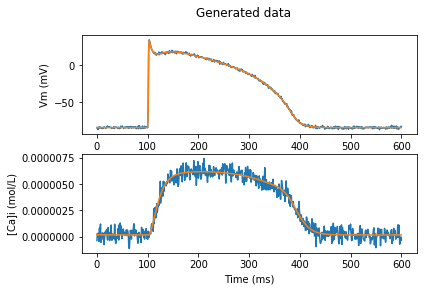

In [3]:
# Create a model
model = MyokitModel()

# Generate some 'experimental' data
x_true = np.array([4, 0.003, 0.09, 0.35, 0.8])
times = np.linspace(0, 600, 601)
values = model.simulate(x_true, times)
print(values.shape)

# Add noise
noisy_values = np.array(values, copy=True)
noisy_values[:, 0] += np.random.normal(0, 1, values[:, 0].shape)
noisy_values[:, 1] += np.random.normal(0, 5e-7, values[:, 1].shape)

plt.figure()
plt.suptitle('Generated data')
plt.subplot(2, 1, 1)
plt.xlabel('Time (ms)')
plt.ylabel('Vm (mV)')
plt.plot(times, noisy_values[:, 0])
plt.plot(times, values[:, 0])
plt.subplot(2, 1, 2)
plt.xlabel('Time (ms)')
plt.ylabel('[Ca]i (mol/L)')
plt.plot(times, noisy_values[:, 1])
plt.plot(times, values[:, 1])
plt.show()

In [4]:

# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, noisy_values)

# Create a score function
weights = [1 / 70, 1 / 0.000006]
score = pints.SumOfSquaresError(problem, weights=weights)

# Select some boundaries
lower = x_true / 2
upper = x_true * 2
boundaries = pints.RectangularBoundaries(lower, upper)

# Perform an optimization
x0 = x_true * 1.2
optimiser = pints.OptimisationController(
    score, x0, boundaries=boundaries, method=pints.CMAES)

print('Running...')
x_found, score_found = optimiser.run()

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(x_found):
    print(pints.strfloat(x) + '    ' + pints.strfloat(x_true[k]))

Running...
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      34.80055   0:00.1
1     16     15.37592   0:00.2
2     24     15.36726   0:00.2
3     32     14.45136   0:00.2
20    168    12.1808    0:00.9
40    328    12.10605   0:01.7
60    488    12.10303   0:02.6
80    648    12.10129   0:03.4
100   808    12.10129   0:04.1
120   968    12.10129   0:05.0
140   1128   12.10129   0:05.8
160   1288   12.07023   0:06.7
180   1448   11.6726    0:07.5
200   1608   11.14485   0:08.2
220   1768   11.13528   0:09.2
240   1928   11.13403   0:10.0
260   2088   11.13354   0:10.7
280   2248   11.13348   0:11.4
300   2408   11.13301   0:12.1
320   2568   11.13301   0:12.9
340   2728   11.13301   0:13.6
360   2888   11.13301   0:14.4
380   3048   11.13301   0:15.2
400   3208   11.13301   0:15.9
420   3368   11.13301   0:16.6
440   3528   11.13301   0:17.4
460   3688   11.1

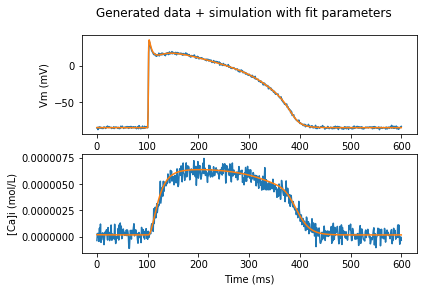

In [5]:

fitted_values = problem.evaluate(x_found)

plt.figure()
plt.suptitle('Generated data + simulation with fit parameters')
plt.subplot(2, 1, 1)
plt.xlabel('Time (ms)')
plt.ylabel('Vm (mV)')
plt.plot(times, noisy_values[:, 0])
plt.plot(times, fitted_values[:, 0])
plt.subplot(2, 1, 2)
plt.xlabel('Time (ms)')
plt.ylabel('[Ca]i (mol/L)')
plt.plot(times, noisy_values[:, 1])
plt.plot(times, fitted_values[:, 1])
plt.show()


## Summary